In [0]:
#code to load the data in the colab notebook
#if this is being run on some other jupyter notebook, we need to write the code to load the data
!unzip -q "/content/drive/My Drive/20_newsgroups.zip"

In [2]:
pip install num2words

     |████████████████████████████████| 102kB 2.9MB/s 


In [0]:
from collections import defaultdict
from collections import Counter
from num2words import num2words
from sklearn.manifold import TSNE

import re
import os
import math
import nltk
import numpy as np
import heapq
import matplotlib.pyplot as plt

**pre-process data**

In [0]:
import re

def pre_process(file):
  f = open(file,'r',encoding="ISO-8859-1")
  data = f.readlines()
  docs = []

  for sent in data:
    sent = re.sub(r'[\.•,;:!#=?$%^&*_~><\(\)\{\}\[\]\"\'\|]','',sent)
    docs.append(sent.lower())
  return docs

**number to words**

In [0]:
def numberTowords(word):
  if(word.isnumeric()):
    return num2words(word)
  else:
    return word

**remove stop words**

In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def removeStop(tokens):
  stop = set(stopwords.words('english'))
  f_tokens = []
  
  for w in tokens:
    if w not in stop:
      f_tokens.append(w)
  
  return f_tokens

**generate tokens**

In [8]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lm = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def tokenise(docs):
  i = 0
  lem_words = []

  for k in docs:
    tokens = k.split()
    f_tokens = removeStop(tokens)

    for j in f_tokens:
      lem_words.append(lm.lemmatize(j))
    
  return lem_words

**remove meta data**

In [0]:
import re
def meta_data(path,f):
    output = []
    with open(os.path.join(path,f),"r+",encoding="ISO-8859-1") as fh:
        for line in fh:
            if not re.search("[\w]+:\s",line):
                output.append(line)
        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.writelines(output)
        fh.close()
        newoutput=[]
        fh=open(os.path.join(path,f),"r+",encoding="ISO-8859-1")
        for line in fh:
            if not re.search("(--)+|(==)+",line):
                newoutput.append(line)
            else:
                break

        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.seek(0)
        fh.truncate()
        fh.writelines(newoutput)
        fh.close()

**mapping docs to docID**

In [0]:
directory = sorted(["comp.graphics","rec.sport.hockey","sci.med","sci.space","talk.politics.misc"])

In [0]:
path = "/content/20_newsgroups/"

mapping = defaultdict(int)
count=0
for d in directory:
  flist = []
  d_path = path+d                   # path that will lead us inside the directory
  flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
  for i in flist:
    count = count+1
    mapping[d+'/'+i] = count

**creating inverted_index**

In [0]:
inverted_index = defaultdict(list)

wd_count = defaultdict(lambda:defaultdict(lambda:0))      # 2D dictionary that stores term frequency(tf)
w_count = defaultdict(lambda:0)                           # 1D dictionary that stores document frequency(df)

documents = 0                       # represents total number of documents in the collection

for d in directory:
  flist = []
  d_path = path+d                   # path that will lead us inside the directory
  flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
  
  for i in flist:
    documents = documents+1
    meta_data(d_path,i)
    pre_p = pre_process(d_path+'/'+i)
    lemmas = tokenise(pre_p)

    for term in lemmas:
      term = numberTowords(term)
      inverted_index[term].append(mapping.get(d+'/'+i))
      wd_count[mapping[d+'/'+i]][term] += 1
      w_count[term] = w_count[term] + 1

**creating tf-idf matrix**

In [0]:
tf = defaultdict(lambda:defaultdict(lambda:0.0))
idf = defaultdict(lambda:0.0)

for i in wd_count:
  for j in wd_count[i]:
    temp = wd_count[i][j]
    tf[i][j] = 1 + math.log((1 + temp),10)

for j in w_count:
  temp = 1 + w_count[j]
  idf[j]= math.log((documents/temp),10)

**PART-1**

**adding tf-idf weights in the inverted_index**

In [0]:
new_index = defaultdict(lambda:defaultdict(lambda:0.0))

for i in wd_count:
  for j in wd_count[i]:
    new_index[i][j] = tf[i][j] * idf[j]

**PART -2**

**ROCCHIO ALGORITHM**

Building vocabulary

In [0]:
vocab = []
for i in inverted_index:
  vocab.append(i)

**cosine similarity**

magnitude of a vector

In [0]:
import math

def magnitude(v):
  n = len(v)
  mag = 0
  for i in v:
    mag = mag + v[i]*v[i]
  mag = mag **0.5

  return mag

generate query vector

In [0]:
def generate_vector(q_terms):
  q_vector = defaultdict(lambda:0.0)

  q_tf = Counter(q_terms)

  for i in q_terms:
    q_vector[i] = (1 + math.log((1 + q_tf[i]),10))*(math.log((documents/(1+w_count[i])),10))

  return q_vector

calculate similarity with all docs

In [0]:
def similarity(q_vector):
  cosine = 0
  scores = []

  q_mag = magnitude(q_vector)

  for d in new_index:
    d_mag = magnitude(new_index[d])

    product = 0
    for w in q_vector:
      # if(q_vector[w]!=0):
      product = product + (q_vector[w] * new_index[d][w])

    cosine = product/(q_mag * d_mag)
    scores.append((cosine,d))
  
  topmost = heapq.nlargest(k,scores)

  return topmost

**calculate centroid**

In [0]:
def centroid(doc_list):
  sumd = 0
  d_list = []
  centroid_vector = defaultdict(lambda:0.0)
  
  #calculating centroid
  for w in vocab:
    for d in doc_list:
      if w in new_index[d]:
        centroid_vector[w] = centroid_vector[w] + new_index[d][w]
        # sumd = sumd + new_index[d][w]
  
  #normalising the centroid vector
  n = len(doc_list)
  for i in centroid_vector:
    centroid_vector[i] = centroid_vector.get(i)/n
  
  return centroid_vector

**user feedback**

In [0]:
def feedback(topmost):

  output=[]
  rel = []
  nrel = []
  for i in topmost:
    output.append(i[1])

  u_input = input("\nEnter the relevant docIDs: ").split()
  
  for i in u_input:
    rel.append(int(i))
  
  nrel = set(output)-set(rel)

  return rel,list(nrel)

**pre-processing query**

In [0]:
def pre_process_query(query):
  query = (re.sub(r'[\.•,;:?!#=$%^&*_~><\-\(\)\{\}\[\]\"\']','',query)).lower()

  q_tokens = []

  temp = removeStop(query.split())

  for j in temp:
    q_tokens.append(lm.lemmatize(j))

  q_terms = []

  for i in q_tokens:
    q_terms.append(numberTowords(i))

  return q_terms

**find results**

In [0]:
def display_result(topmost):

  print("\nThe top ",k," results are :")
  print("DocID \t Document Name")
  for i in range(k):
    dID = topmost[i][1]

    for j in mapping.items():
      if(j[1]==dID):
        if(j[1] in rel_docs):
          print("*",j[1],"\t",j[0])         # j[0] contains doc name and j[1] contains docID
        else:
          print(j[1],"\t",j[0]) 
        break;

In [0]:
def find_result(query):
 
  qtokens = pre_process_query(query)
  q_vector = generate_vector(qtokens)
  q_new = defaultdict(lambda:0.0)

  for i in range(iterations):
    if(i==0):
      q_new = q_vector
    else:
      print("\nRelevance Feedback ",i+1,"\n")

      rel = centroid(rel_docs)
      non_rel = centroid(non_rel_docs)

      for l in rel:
        rel[l] = rel.get(l) * beta

      for j in non_rel:
        non_rel[j] = non_rel.get(j) * gamma
      
      for k in q_old:
        q_old[k] = q_old[k] * alpha
      
      #computing modified query vector
      for w in vocab:
        q_new[w] = q_old[w] + abs(rel[w] - non_rel[w])

    res = similarity(q_new)
    
    display_result(res)
    
    r, nr = feedback(res)

    # updating the list of relevant documents, 
    # r contains the docIDs entered by the user in this iteration
    for d in r:
      rel_docs.add(d)

    # for storing the non-relevant documents of this iteration
    nr_current = []

    for d in nr:
      if(d not in rel_docs):
        non_rel_docs.add(d)
        nr_current.append(d)
    
    print("\nRelevant docIDs uptil now for the user given query: ",rel_docs)

    pr_curve(res)
    print("TNSE plot for iteration",i," :-\n")

    tnse_plot(r,nr_current,q_new)
    
    #after the end of iteration, the modified query vector now becomes old
    q_old = q_new


**drawing curves**

In [0]:
def pr_curve(res):
  precision = list()
  recall = list()
  map_val = 0

  rel_total = 1000
  rel_retrieved = 0
  retrieved_docs =0
  relevancy = 0

  i = 0
  for i in range(0,k):
    retrieved_docs = i+1
    
    if(res[i][1] in rel_docs):
      rel_retrieved += 1
      relevancy = 1
    else:
      relevancy = 0

    p_val = rel_retrieved/retrieved_docs
    r_val = rel_retrieved/rel_total
    map_val += p_val * relevancy

    precision.append(p_val)
    recall.append(r_val)
    i += 1

  print("\nMean Average Precision(MAP) for the above query is: ", map_val/rel_retrieved)
  plt.plot(recall,precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title("PRECISION-RECALL CURVE")
  plt.show()

TNSE plot

In [0]:
def tnse_plot(rel_docs,non_rel_docs,query):
  tnse = TSNE(n_components=2, random_state=0)

  data = []
  labels =[]

  for d in rel_docs:
    d_vector = []
    for w in vocab:
      d_vector.append(new_index[d][w])
    data.append(d_vector)
    labels.append(0)
  
  for d in non_rel_docs:
    nd_vector = []
    for w in vocab:
      nd_vector.append(new_index[d][w])
    data.append(nd_vector)
    labels.append(1)

  vec = []
  for w in vocab:
    vec.append(query[w])
  data.append(vec)
  labels.append(2)

  transformed_data = tnse.fit_transform(np.array(data))
  k = np.array(transformed_data)
  t = ("Relevant", "Non Relevant", "Query")
  plt.scatter(k[:, 0], k[:, 1], c=labels, s=60, alpha=0.8, label="Violet=Rel\nAqua=NonRel\nYellow=query")
  plt.title("TNSretrieved_docsE plot")
  plt.legend()
  # plt.grid(True)
  plt.show()

###user input

In [0]:
query1 = "Pretty good opinions on biochemistry machines"
query2 = "Scientific tools for preserving rights and body"
query3 = "Frequently asked questions on State-of-the-art visualisation tools"

In [0]:
alpha = 1
beta = 0.7
gamma = 0.25

In [97]:
iterations = int(input("Enter the number of relevance feedbacks : "))

k = int(input("Enter the number of results you want in each iteration : "))    #top k results to be shown to user in each iteration

# p = 15
# user will mark p% of the relevant results retrieved

Enter the number of relevance feedbacks : 4
Enter the number of results you want in each iteration : 100



The top  100  results are :
DocID 	 Document Name
944 	 comp.graphics/38523
2097 	 sci.med/59429
234 	 comp.graphics/38597
2376 	 sci.med/58082
779 	 comp.graphics/38774
2708 	 sci.med/59393
926 	 comp.graphics/38240
2029 	 sci.med/59564
223 	 comp.graphics/38538
2281 	 sci.med/58987
860 	 comp.graphics/38837
1529 	 rec.sport.hockey/53677
399 	 comp.graphics/38629
2947 	 sci.med/59043
3444 	 sci.space/61454
235 	 comp.graphics/38959
2790 	 sci.med/59504
1596 	 rec.sport.hockey/54075
998 	 comp.graphics/38869
1972 	 rec.sport.hockey/52653
3418 	 sci.space/61522
2782 	 sci.med/59355
4860 	 talk.politics.misc/178358
2979 	 sci.med/59233
257 	 comp.graphics/38955
1470 	 rec.sport.hockey/53791
696 	 comp.graphics/38759
1744 	 rec.sport.hockey/53646
2038 	 sci.med/59238
791 	 comp.graphics/38438
196 	 comp.graphics/38442
4454 	 talk.politics.misc/176883
129 	 comp.graphics/38524
4659 	 talk.politics.misc/179047
706 	 comp.graphics/39630
486 	 comp.graphics/38994
4190 	 talk.politics.misc/17

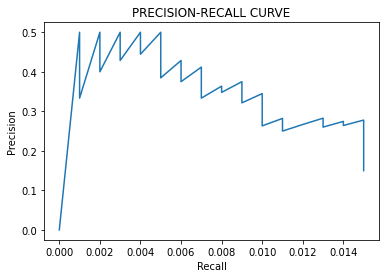

TNSE plot for iteration 0  :-



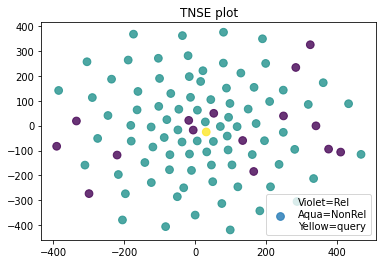


Relevance Feedback  2 


The top  100  results are :
DocID 	 Document Name
* 2066 	 sci.med/59488
* 2967 	 sci.med/58872
* 2979 	 sci.med/59233
* 2038 	 sci.med/59238
* 2326 	 sci.med/59301
* 2947 	 sci.med/59043
* 2790 	 sci.med/59504
* 2281 	 sci.med/58987
2559 	 sci.med/59518
* 2376 	 sci.med/58082
* 2708 	 sci.med/59393
2210 	 sci.med/59183
2631 	 sci.med/59165
944 	 comp.graphics/38523
2680 	 sci.med/59063
* 2517 	 sci.med/58801
2170 	 sci.med/59207
2278 	 sci.med/59323
2349 	 sci.med/59060
* 2097 	 sci.med/59429
2932 	 sci.med/59116
2530 	 sci.med/58982
2650 	 sci.med/59554
234 	 comp.graphics/38597
* 2029 	 sci.med/59564
2526 	 sci.med/59490
2297 	 sci.med/59459
63 	 comp.graphics/38554
2422 	 sci.med/59548
* 2717 	 sci.med/59259
4386 	 talk.politics.misc/178382
* 2782 	 sci.med/59355
2891 	 sci.med/58065
2590 	 sci.med/59385
2963 	 sci.med/59069
2276 	 sci.med/59034
1797 	 rec.sport.hockey/53827
2933 	 sci.med/59333
2688 	 sci.med/58139
2668 	 sci.med/59234
2043 	 sci.med/5815

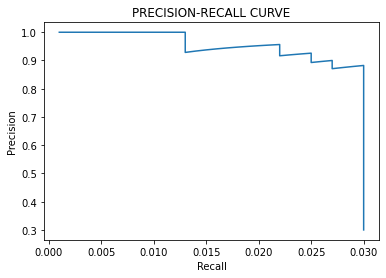

TNSE plot for iteration 1  :-



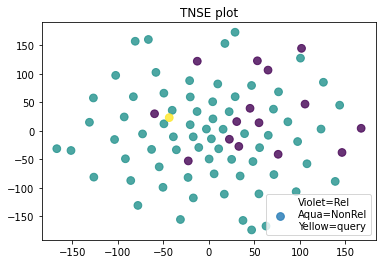


Relevance Feedback  3 


The top  100  results are :
DocID 	 Document Name
* 2066 	 sci.med/59488
* 2210 	 sci.med/59183
* 2631 	 sci.med/59165
* 2790 	 sci.med/59504
* 2559 	 sci.med/59518
* 2278 	 sci.med/59323
* 2650 	 sci.med/59554
* 2979 	 sci.med/59233
* 2967 	 sci.med/58872
* 2170 	 sci.med/59207
* 2326 	 sci.med/59301
* 2947 	 sci.med/59043
* 2038 	 sci.med/59238
* 2422 	 sci.med/59548
* 2526 	 sci.med/59490
* 2281 	 sci.med/58987
* 2297 	 sci.med/59459
* 2708 	 sci.med/59393
* 2376 	 sci.med/58082
2933 	 sci.med/59333
* 2932 	 sci.med/59116
* 2530 	 sci.med/58982
2440 	 sci.med/59322
* 2680 	 sci.med/59063
2963 	 sci.med/59069
2331 	 sci.med/59447
2276 	 sci.med/59034
* 2349 	 sci.med/59060
* 2590 	 sci.med/59385
2244 	 sci.med/59049
* 2891 	 sci.med/58065
4386 	 talk.politics.misc/178382
* 2517 	 sci.med/58801
2256 	 sci.med/59432
2981 	 sci.med/59338
2625 	 sci.med/59209
2668 	 sci.med/59234
3306 	 sci.space/61244
2009 	 sci.med/58152
63 	 comp.graphics/38554
3647 	 sci.spa

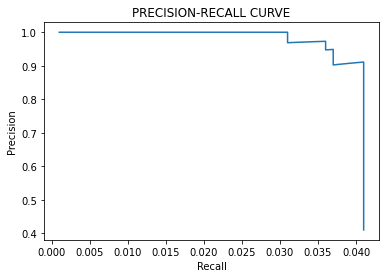

TNSE plot for iteration 2  :-



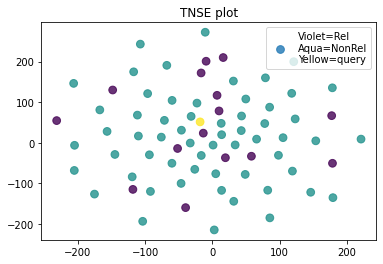


Relevance Feedback  4 


The top  100  results are :
DocID 	 Document Name
* 2210 	 sci.med/59183
* 2066 	 sci.med/59488
* 2631 	 sci.med/59165
* 2278 	 sci.med/59323
* 2559 	 sci.med/59518
* 2650 	 sci.med/59554
* 2790 	 sci.med/59504
* 2170 	 sci.med/59207
* 2933 	 sci.med/59333
* 2979 	 sci.med/59233
* 2967 	 sci.med/58872
* 2422 	 sci.med/59548
* 2526 	 sci.med/59490
* 2440 	 sci.med/59322
* 2963 	 sci.med/59069
* 2276 	 sci.med/59034
* 2244 	 sci.med/59049
* 2326 	 sci.med/59301
* 2947 	 sci.med/59043
* 2038 	 sci.med/59238
* 2297 	 sci.med/59459
* 2331 	 sci.med/59447
* 2981 	 sci.med/59338
* 2009 	 sci.med/58152
* 2281 	 sci.med/58987
* 2955 	 sci.med/59318
2762 	 sci.med/59332
* 2625 	 sci.med/59209
* 2932 	 sci.med/59116
* 2668 	 sci.med/59234
* 2530 	 sci.med/58982
* 2708 	 sci.med/59393
* 3000 	 sci.med/58984
* 2256 	 sci.med/59432
* 2590 	 sci.med/59385
* 2891 	 sci.med/58065
* 2376 	 sci.med/58082
* 2043 	 sci.med/58155
* 2680 	 sci.med/59063
4386 	 talk.politics.misc/178

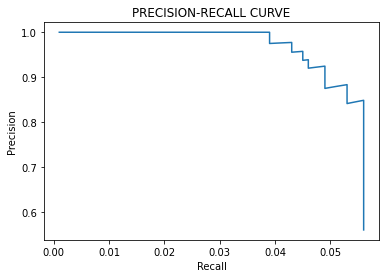

TNSE plot for iteration 3  :-



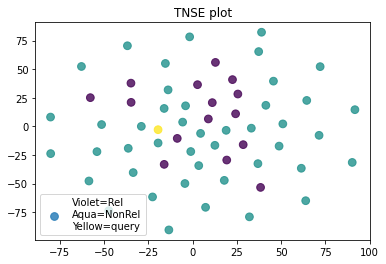

In [104]:
rel_docs = set()
non_rel_docs = set()
find_result(query1)


The top  100  results are :
DocID 	 Document Name
590 	 comp.graphics/39736
2855 	 sci.med/59269
2235 	 sci.med/58775
2291 	 sci.med/58053
171 	 comp.graphics/37920
3063 	 sci.space/60797
331 	 comp.graphics/38409
2997 	 sci.med/59273
2550 	 sci.med/58977
3544 	 sci.space/60809
2163 	 sci.med/59372
3409 	 sci.space/61335
2315 	 sci.med/59434
458 	 comp.graphics/39655
3499 	 sci.space/60820
191 	 comp.graphics/38272
3337 	 sci.space/61385
389 	 comp.graphics/39074
2110 	 sci.med/59587
2447 	 sci.med/58867
2186 	 sci.med/59596
2688 	 sci.med/58139
2885 	 sci.med/58958
3997 	 sci.space/59871
4782 	 talk.politics.misc/178540
2496 	 sci.med/58902
2143 	 sci.med/58895
2869 	 sci.med/58939
3340 	 sci.space/61145
4960 	 talk.politics.misc/178340
68 	 comp.graphics/38912
4357 	 talk.politics.misc/178352
2218 	 sci.med/59547
2361 	 sci.med/58880
2246 	 sci.med/58956
1241 	 rec.sport.hockey/53556
3459 	 sci.space/61482
275 	 comp.graphics/39021
2397 	 sci.med/58938
3830 	 sci.space/60872
643 	 c

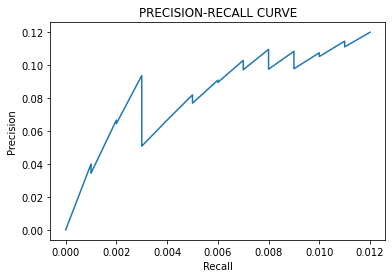

TNSE plot for iteration 0  :-



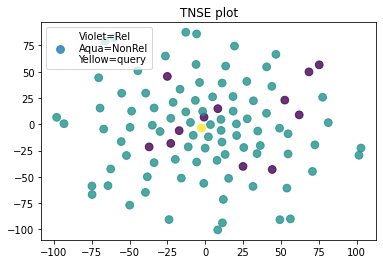


Relevance Feedback  2 


The top  100  results are :
DocID 	 Document Name
* 4782 	 talk.politics.misc/178540
* 4192 	 talk.politics.misc/178546
* 4960 	 talk.politics.misc/178340
4367 	 talk.politics.misc/178695
* 4059 	 talk.politics.misc/176850
* 4143 	 talk.politics.misc/178802
4626 	 talk.politics.misc/178587
* 4280 	 talk.politics.misc/178752
* 4237 	 talk.politics.misc/179045
* 4756 	 talk.politics.misc/177022
* 4190 	 talk.politics.misc/179106
5000 	 talk.politics.misc/178817
* 4357 	 talk.politics.misc/178352
* 4359 	 talk.politics.misc/178523
4711 	 talk.politics.misc/178431
4316 	 talk.politics.misc/178733
3409 	 sci.space/61335
2315 	 sci.med/59434
4245 	 talk.politics.misc/178492
3997 	 sci.space/59871
4595 	 talk.politics.misc/178475
2218 	 sci.med/59547
2688 	 sci.med/58139
3020 	 sci.space/60196
4377 	 talk.politics.misc/178349
4839 	 talk.politics.misc/178329
4620 	 talk.politics.misc/178721
2210 	 sci.med/59183
3483 	 sci.space/61009
2865 	 sci.med/59468
3948 	 sci.s

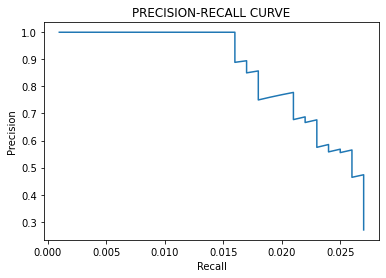

TNSE plot for iteration 1  :-



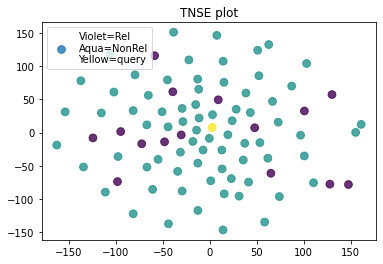


Relevance Feedback  3 


The top  100  results are :
DocID 	 Document Name
* 4782 	 talk.politics.misc/178540
* 4192 	 talk.politics.misc/178546
* 4367 	 talk.politics.misc/178695
* 4626 	 talk.politics.misc/178587
* 4960 	 talk.politics.misc/178340
* 4386 	 talk.politics.misc/178382
* 4245 	 talk.politics.misc/178492
* 4377 	 talk.politics.misc/178349
* 4631 	 talk.politics.misc/178528
* 4143 	 talk.politics.misc/178802
* 4839 	 talk.politics.misc/178329
* 4280 	 talk.politics.misc/178752
* 4059 	 talk.politics.misc/176850
* 4595 	 talk.politics.misc/178475
* 5000 	 talk.politics.misc/178817
* 4711 	 talk.politics.misc/178431
* 4237 	 talk.politics.misc/179045
* 4510 	 talk.politics.misc/178434
4910 	 talk.politics.misc/178519
* 4316 	 talk.politics.misc/178733
* 4756 	 talk.politics.misc/177022
4027 	 talk.politics.misc/178944
4613 	 talk.politics.misc/178422
* 4620 	 talk.politics.misc/178721
* 4359 	 talk.politics.misc/178523
2210 	 sci.med/59183
* 4357 	 talk.politics.misc/178352

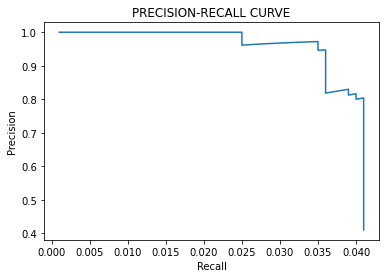

TNSE plot for iteration 2  :-



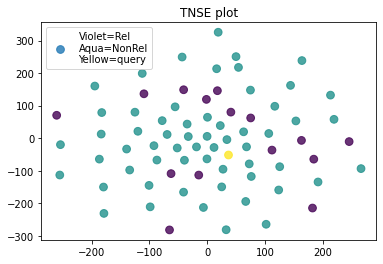


Relevance Feedback  4 


The top  100  results are :
DocID 	 Document Name
* 4782 	 talk.politics.misc/178540
* 4192 	 talk.politics.misc/178546
* 4367 	 talk.politics.misc/178695
* 4386 	 talk.politics.misc/178382
* 4626 	 talk.politics.misc/178587
* 4631 	 talk.politics.misc/178528
* 4377 	 talk.politics.misc/178349
* 4245 	 talk.politics.misc/178492
* 4960 	 talk.politics.misc/178340
* 4839 	 talk.politics.misc/178329
* 4613 	 talk.politics.misc/178422
* 4143 	 talk.politics.misc/178802
* 4910 	 talk.politics.misc/178519
* 4027 	 talk.politics.misc/178944
* 4128 	 talk.politics.misc/178453
* 4510 	 talk.politics.misc/178434
* 4749 	 talk.politics.misc/178416
* 4739 	 talk.politics.misc/178417
* 4595 	 talk.politics.misc/178475
* 4814 	 talk.politics.misc/176970
* 4013 	 talk.politics.misc/178449
* 4280 	 talk.politics.misc/178752
* 4059 	 talk.politics.misc/176850
* 5000 	 talk.politics.misc/178817
* 4942 	 talk.politics.misc/178493
* 4544 	 talk.politics.misc/178413
* 4711 	 talk.

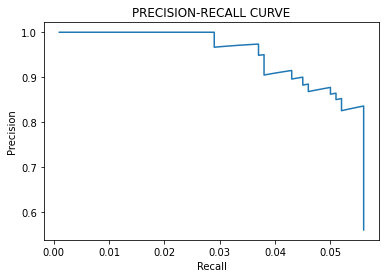

TNSE plot for iteration 3  :-



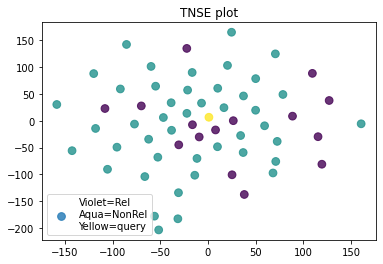

In [99]:
rel_docs = set()
non_rel_docs = set()
find_result(query2)


The top  100  results are :
DocID 	 Document Name
2533 	 sci.med/59324
2723 	 sci.med/58577
742 	 comp.graphics/38962
1666 	 rec.sport.hockey/53468
312 	 comp.graphics/38778
797 	 comp.graphics/38226
7 	 comp.graphics/38497
4960 	 talk.politics.misc/178340
4782 	 talk.politics.misc/178540
590 	 comp.graphics/39736
3472 	 sci.space/61146
2680 	 sci.med/59063
3787 	 sci.space/62373
893 	 comp.graphics/38434
2606 	 sci.med/59061
427 	 comp.graphics/38400
2390 	 sci.med/59310
905 	 comp.graphics/39014
2858 	 sci.med/59079
2581 	 sci.med/59064
4192 	 talk.politics.misc/178546
4175 	 talk.politics.misc/178451
289 	 comp.graphics/38692
1806 	 rec.sport.hockey/53908
191 	 comp.graphics/38272
2715 	 sci.med/59185
2450 	 sci.med/59100
4626 	 talk.politics.misc/178587
574 	 comp.graphics/39495
2688 	 sci.med/58139
3299 	 sci.space/60103
3063 	 sci.space/60797
2545 	 sci.med/59145
2524 	 sci.med/59026
331 	 comp.graphics/38409
4367 	 talk.politics.misc/178695
2306 	 sci.med/58077
83 	 comp.graphi

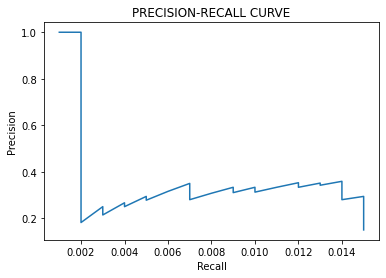

TNSE plot for iteration 0  :-



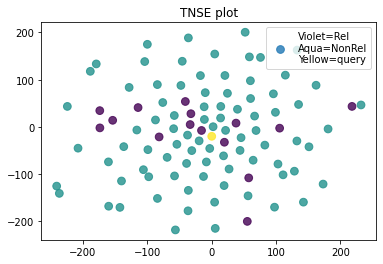


Relevance Feedback  2 


The top  100  results are :
DocID 	 Document Name
* 2858 	 sci.med/59079
* 2581 	 sci.med/59064
* 2450 	 sci.med/59100
* 2167 	 sci.med/59178
* 2688 	 sci.med/58139
* 2723 	 sci.med/58577
* 2533 	 sci.med/59324
* 2680 	 sci.med/59063
* 2390 	 sci.med/59310
* 2524 	 sci.med/59026
* 2545 	 sci.med/59145
* 2606 	 sci.med/59061
312 	 comp.graphics/38778
742 	 comp.graphics/38962
* 2931 	 sci.med/58875
1666 	 rec.sport.hockey/53468
797 	 comp.graphics/38226
4782 	 talk.politics.misc/178540
* 2715 	 sci.med/59185
* 2306 	 sci.med/58077
4960 	 talk.politics.misc/178340
3472 	 sci.space/61146
2684 	 sci.med/59098
2619 	 sci.med/59009
2947 	 sci.med/59043
3787 	 sci.space/62373
893 	 comp.graphics/38434
4626 	 talk.politics.misc/178587
4192 	 talk.politics.misc/178546
7 	 comp.graphics/38497
4367 	 talk.politics.misc/178695
427 	 comp.graphics/38400
2256 	 sci.med/59432
905 	 comp.graphics/39014
289 	 comp.graphics/38692
2996 	 sci.med/59087
2702 	 sci.med/58868
2038 	

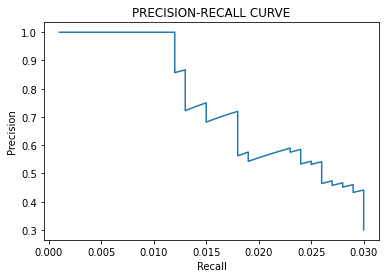

TNSE plot for iteration 1  :-



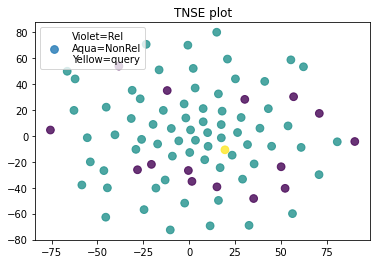


Relevance Feedback  3 


The top  100  results are :
DocID 	 Document Name
* 2858 	 sci.med/59079
* 2581 	 sci.med/59064
* 2450 	 sci.med/59100
* 2167 	 sci.med/59178
* 2210 	 sci.med/59183
* 2688 	 sci.med/58139
* 2668 	 sci.med/59234
* 2998 	 sci.med/59189
* 2680 	 sci.med/59063
* 2220 	 sci.med/58109
* 2947 	 sci.med/59043
* 2723 	 sci.med/58577
* 2390 	 sci.med/59310
* 2524 	 sci.med/59026
* 2533 	 sci.med/59324
2631 	 sci.med/59165
* 2038 	 sci.med/59238
2620 	 sci.med/59255
* 2619 	 sci.med/59009
* 2684 	 sci.med/59098
* 2996 	 sci.med/59087
* 2256 	 sci.med/59432
* 2545 	 sci.med/59145
* 2522 	 sci.med/58844
* 2010 	 sci.med/59162
* 2931 	 sci.med/58875
* 2606 	 sci.med/59061
* 2702 	 sci.med/58868
3409 	 sci.space/61335
* 2315 	 sci.med/59434
312 	 comp.graphics/38778
2276 	 sci.med/59034
797 	 comp.graphics/38226
* 2306 	 sci.med/58077
742 	 comp.graphics/38962
2297 	 sci.med/59459
4782 	 talk.politics.misc/178540
* 2361 	 sci.med/58880
1666 	 rec.sport.hockey/53468
2963 	 sc

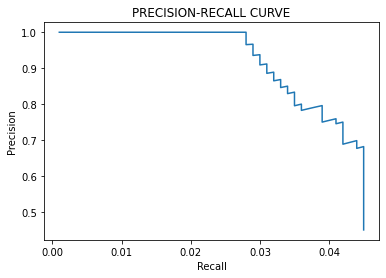

TNSE plot for iteration 2  :-



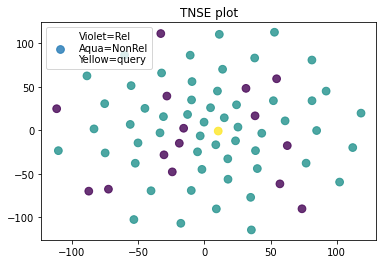


Relevance Feedback  4 


The top  100  results are :
DocID 	 Document Name
* 2858 	 sci.med/59079
* 2581 	 sci.med/59064
* 2450 	 sci.med/59100
* 2167 	 sci.med/59178
* 2210 	 sci.med/59183
* 2668 	 sci.med/59234
* 2998 	 sci.med/59189
* 2631 	 sci.med/59165
* 2688 	 sci.med/58139
* 2620 	 sci.med/59255
* 2220 	 sci.med/58109
* 2276 	 sci.med/59034
* 2680 	 sci.med/59063
* 2963 	 sci.med/59069
* 2244 	 sci.med/59049
* 2947 	 sci.med/59043
* 2256 	 sci.med/59432
* 2650 	 sci.med/59554
* 2066 	 sci.med/59488
* 2038 	 sci.med/59238
* 2619 	 sci.med/59009
* 2996 	 sci.med/59087
* 2297 	 sci.med/59459
* 2010 	 sci.med/59162
* 2390 	 sci.med/59310
* 2524 	 sci.med/59026
* 2723 	 sci.med/58577
* 2684 	 sci.med/59098
* 2522 	 sci.med/58844
* 2702 	 sci.med/58868
* 2625 	 sci.med/59209
* 2815 	 sci.med/59380
* 2533 	 sci.med/59324
* 2545 	 sci.med/59145
3409 	 sci.space/61335
* 2315 	 sci.med/59434
* 2511 	 sci.med/58891
* 2931 	 sci.med/58875
* 2361 	 sci.med/58880
* 2475 	 sci.med/59505
2278

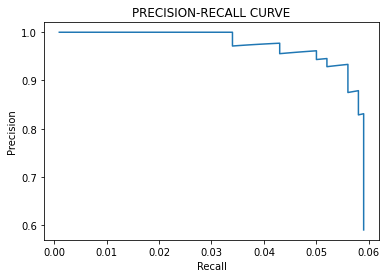

TNSE plot for iteration 3  :-



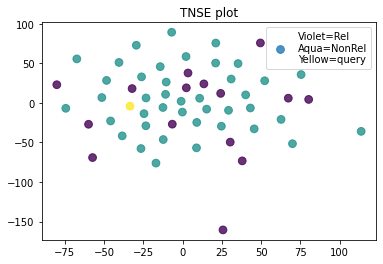

In [100]:
rel_docs = set()
non_rel_docs = set()
find_result(query3)